In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/07_MLP_torch_loop.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# MLP

- Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

## 1.- Preprocesamiento

In [2]:
!pip install keras==3.0.0 --upgrade --quiet

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import pandas as pd
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

torch.__version__, keras.__version__

('2.2.1+cu121', '3.0.0')

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [6]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


- Agregar etiquetas de clase

In [7]:
fake_df['target'] = 1
true_df['target'] = 0

In [8]:
len(fake_df), len(true_df)

(23481, 21417)

In [9]:
fake_df.tail()

,title,text,subject,date,target
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


- Crea un df de los dos archivos

In [10]:
df = pd.concat([true_df, fake_df])
df = df.reset_index(drop=True) # Create id to avoid nan and replicate id bug
df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [11]:
df.tail()

,title,text,subject,date,target
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


- Verifica cadenas vacias

In [12]:
df['text'].isna().sum()

0

In [13]:
len(df)

44898

- Elimina duplicados

In [14]:
df = df.drop_duplicates(subset=['text'])
len(df)

38646

In [15]:
df.head(10)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",0
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",0
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",0
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",0


In [16]:
df.sort_values(by='text', ascending=True, inplace=False)

,title,text,subject,date,target
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",0
33661,TRUMP SLAMS THE GLOBALISTS: “There is no globa...,,politics,"Dec 1, 2016",1
35094,MUSLIM INVASION OF AMERICA In Full Swing: Obam...,(Welcome) to America We hope you enjoy our...,politics,"Jun 17, 2016",1
32062,WOW! MAJOR CREDIT CARD COMPANY Still Sponsorin...,Delta Air Lines and Bank of America became ...,politics,"Jun 12, 2017",1
33502,A MUST WATCH! “It’s Time To Show America Is Bi...,#PresidentElectTrumpABSOLUTELY MUST WATCHTod...,politics,"Dec 21, 2016",1
...,...,...,...,...,...
33499,OHIO ELECTOR TORCHES Anti-Trump Letters He Rec...,pic.twitter.com/KMnLrwB6t1 Richard K. Jones (...,politics,"Dec 21, 2016",1
42714,EMBARRASSING: Obama Explains How He Will ‘Rebu...,re buke r byo ok/ verb 1. express sharp disapp...,left-news,"Nov 25, 2015",1
36178,BLACK LIVES MATTER TERRORISTS May Be Shut Down...,ter ror ist ter r st/ noun a person who uses ...,politics,"Dec 23, 2015",1
38658,BIG BROTHER: FEDS WANT YOUR DOCTOR TO WARN YOU...,totally out of bounds! This is so wrong and so...,Government News,"Jun 26, 2015",1


In [17]:
df.loc[8970].text

' '

- Elimina cadenas de espacios

In [18]:
df = df[df['text'].str.strip() != '']
df

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44115,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016",1
44116,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016",1
44117,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016",1
44118,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016",1


In [19]:
df = df.reset_index(drop=True)

In [20]:
len(df)

38644

- Crea nueva columna añadiendo el título al texto

In [21]:
df['clean_text'] = df['title']+ df['text']

In [22]:
df

,title,text,subject,date,target,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,Trump wants Postal Service to charge 'much mor...
...,...,...,...,...,...,...
38639,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016",1,The White House and The Theatrics of ‘Gun Cont...
38640,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016",1,Activists or Terrorists? How Media Controls an...
38641,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016",1,"BOILER ROOM – No Surrender, No Retreat, Heads ..."
38642,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016",1,Federal Showdown Looms in Oregon After BLM Abu...


- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [23]:
import string

In [24]:
df['clean_text'] = df['clean_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
df.head()

,title,text,subject,date,target,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,as us budget fight looms republicans flip thei...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,us military to accept transgender recruits on ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,senior us republican senator let mr mueller do...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,fbi russia probe helped by australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,trump wants postal service to charge much more...


## 2.- Pipeline

In [25]:
df['target'].value_counts()

0    21191
1    17453
Name: target, dtype: int64

In [26]:
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import time

X = df['clean_text'].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [27]:
len(X_train), len(X_test)

(28983, 9661)

In [28]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [29]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
for text in raw_train_ds.take(1):
    print(text)

(<tf.Tensor: shape=(), dtype=string, numpy=b'boom republican wins montana election after \xe2\x80\x9cbodyslamming\xe2\x80\x9d reporter \xe2\x80\x98i\xe2\x80\x99m sick and tired of this\xe2\x80\x99this is just too rich the democrats threw tons of money into this race and then the republican candidate  bodyslammed  an obnoxious reporter it seemed like the dems really couldn t lose this one bernie s socialist candidate would win in montana the democrats were sure they could run leftists and win in red states not so fastrepublican businessman greg gianforte won montana s sole house district in a special election thursday keeping a seat in republican hands despite facing assault charges for allegedly attacking a reporter who d asked him about the gop s healthcare billthe best ever quote from the  bodyslamming  incident is when gianforte spoke for all americans  i m sick and tired of this after he won he commented on the incident in his victory speech i shouldn t have treated that reporter t

In [30]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
start = time.time()
vectorize_layer.adapt(text_ds)
print(f'Time for adapt is {time.time()-start:.4f}')

Time for adapt is 262.7696


In [31]:
batch_size = 16
raw_train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)

In [32]:
for inp, target in raw_train_ds.take(1):
    print(inp[:2], target[:2])

tf.Tensor(
[b'boiler room ep 85 \xe2\x80\x93 the return of the social rejects clubtune in to the alternate current radio network acr for another live broadcast of  the boiler room  starting at 600 pm pst  800 pm cst  900 pm est for this special broadcast join us for uncensored uninterruptible talk radio custommade for barfly philosophers misguided moralists masochists street corner evangelists mediamaniacs savants political animals and otherwise lovable rascalsjoin acr hosts hesher and spore along with jay dyer jamie hanshaw host of happy hearts  andy nowicki of alt right blogspot and daniel spaulding of soul of the east for the 85th episode of boiler room dim the lights dawn the headphones and indulge in a postelection special broadcast of boiler room with the crew this week the boiler mindtrust is going about examining current events like the media aardvarks that they are jamie brings up the odd behaviors of kanye west and the boiler room discusses if he has he gone  startruther  and

In [33]:
vectorize_layer(inp)

tensor([[128.6574,  17.4551,   2.8319,  ...,   0.0000,   0.0000,   0.0000],
        [103.9156,  13.9641,   7.0798,  ...,   0.0000,   0.0000,   0.0000],
        [133.6058,  11.8695,   4.2479,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [138.5541,  16.7569,   9.2037,  ...,   0.0000,   0.0000,   0.0000],
        [ 29.6902,  11.1713,   7.0798,  ...,   0.0000,   0.0000,   0.0000],
        [ 29.6902,   0.6982,   1.4160,  ...,   0.0000,   0.0000,   0.0000]])

In [34]:
def preprocess(x, y):
    x = vectorize_layer(x)
    return x, y

train_ds = raw_train_ds.map(lambda x, y: preprocess(x, y))
val_ds = raw_val_ds.map(lambda x, y: preprocess(x, y))

In [35]:
next(iter(train_ds))

(<tf.Tensor: shape=(16, 10000), dtype=float32, numpy=
 array([[ 59.38034  ,   6.2838492,   9.203724 , ...,   0.       ,
           0.       ,   0.       ],
        [ 54.43198  ,   1.396411 ,   2.1239362, ...,   0.       ,
           0.       ,   0.       ],
        [163.29594  ,  30.022835 ,  19.823404 , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [143.50249  ,  38.401302 ,  14.1595745, ...,   0.       ,
           0.       ,   0.       ],
        [108.86396  ,   5.585644 ,   6.3718085, ...,   0.       ,
           0.       ,   0.       ],
        [ 39.586895 ,   5.585644 ,   2.1239362, ...,   0.       ,
           0.       ,   0.       ]], dtype=float32)>,
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])>)

## 3.- Modelo

In [36]:
class Linear(keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super().__init__()
        self.num_outputs = num_outputs
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=(input_dim, self.num_outputs),
            initializer=keras.initializers.GlorotNormal(),
            name="kernel",
            trainable=True,
        )

        self.b = self.add_weight(
            shape=(self.num_outputs,),
            initializer=keras.initializers.Zeros(),
            name="bias",
            trainable=True,
        )

    def call(self, inputs):
        x = keras.ops.matmul(inputs, self.w) + self.b
        return self.activation(x)

layer = Linear(1)
layer

<Linear name=linear, built=False>

In [37]:
test_batch = next(iter(train_ds))
test_batch[0]

<tf.Tensor: shape=(16, 10000), dtype=float32, numpy=
array([[ 89.07051  ,   8.378466 ,   4.955851 , ...,   0.       ,
          0.       ,   0.       ],
       [ 89.07051  ,  19.549753 ,   4.2478724, ...,   0.       ,
          0.       ,   0.       ],
       [103.915596 ,  20.24796  ,  10.61968  , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [212.77956  ,  20.946163 ,   5.66383  , ...,   0.       ,
          0.       ,   0.       ],
       [138.55414  ,  20.24796  ,  12.743617 , ...,   0.       ,
          0.       ,   0.       ],
       [108.86396  ,   4.8874383,   2.831915 , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)>

In [38]:
class Model(keras.Model):
    def __init__(self):
        super().__init__()
        self.l1 = Linear(3, activation='sigmoid')
        self.l2 = Linear(1)

    def call(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

model = Model()

In [39]:
model(test_batch[0]).shape, test_batch[1].shape

(torch.Size([16, 1]), TensorShape([16]))

In [40]:
model(test_batch[0])[:, 0].shape

torch.Size([16])

In [41]:
loss_fn =  keras.losses.MeanSquaredError()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Prepare the metrics.
train_loss_avg = keras.metrics.Mean()
train_acc_avg = keras.metrics.Accuracy()
train_loss_history = []
train_acc_history = []

In [42]:
epochs = 5
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for inputs, targets in train_ds:
        # Forward pass
        pred = model(inputs)
        loss = loss_fn(targets, pred)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Optimizer variable updates
        optimizer.step()

        train_loss_avg(loss)
        train_acc_avg(targets, keras.ops.round(pred))

    train_loss_history.append(train_loss_avg.result().cpu())
    train_acc_history.append(train_acc_avg.result().cpu())
    print(f"Training loss over epoch: {float(train_loss_avg.result()):.4f}")
    print(f"Training acc over epoch: {float(train_acc_avg.result()):.4f}")
    train_loss_avg.reset_state()
    train_acc_avg.reset_state()


Start of epoch 0
Training loss over epoch: 0.2308
Training acc over epoch: 0.6209

Start of epoch 1
Training loss over epoch: 0.0984
Training acc over epoch: 0.8980

Start of epoch 2
Training loss over epoch: 0.0488
Training acc over epoch: 0.9522

Start of epoch 3
Training loss over epoch: 0.0353
Training acc over epoch: 0.9670

Start of epoch 4
Training loss over epoch: 0.0295
Training acc over epoch: 0.9741


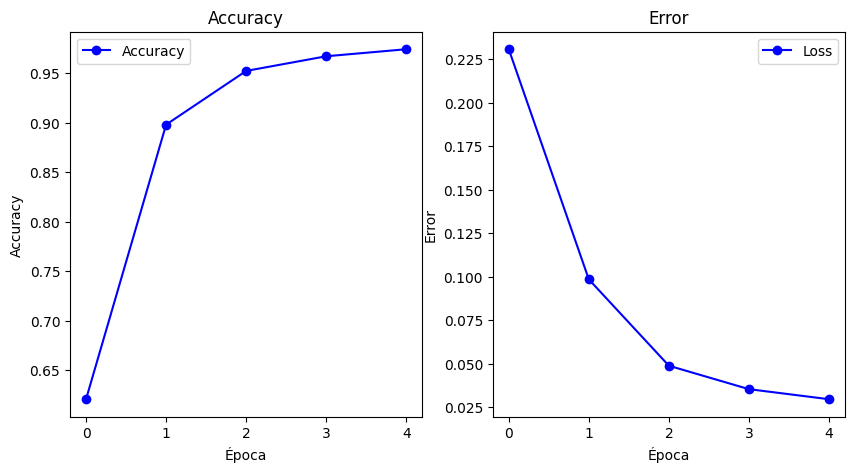

In [43]:
import matplotlib.pyplot as plt
# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot de accuracy en el primer subplot
ax1.plot(train_acc_history, 'bo-', label='Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot de error en el segundo subplot
ax2.plot(train_loss_history, 'bo-', label='Loss')
ax2.set_title('Error')
ax2.set_xlabel('Época')
ax2.set_ylabel('Error')
ax2.legend()

# Mostrar figura
plt.show()

## Ejercicio
- Agregar loop de validación